In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## Prediction using voltage, current, and temperature

In [2]:
real = pd.read_csv("../../DATA/DataFrame/B0006_capacity_df.csv")
MC_LSTM = pd.read_csv("./MC_LSTM.csv")
MC_AttentionLSTM = pd.read_csv("./MC_AttentionLSTM.csv")
MC_1MAttn = pd.read_csv("./MC_1MAttn.csv")
MC_PE_1MAttn = pd.read_csv("./MC_PE_1MAttn.csv")
MC_2MAttn = pd.read_csv("./MC_2MAttn.csv")
MC_PE_2MAttn = pd.read_csv("./MC_PE_2MAttn.csv")

# RNN 계열 VS Attention 계열(NO RNN)

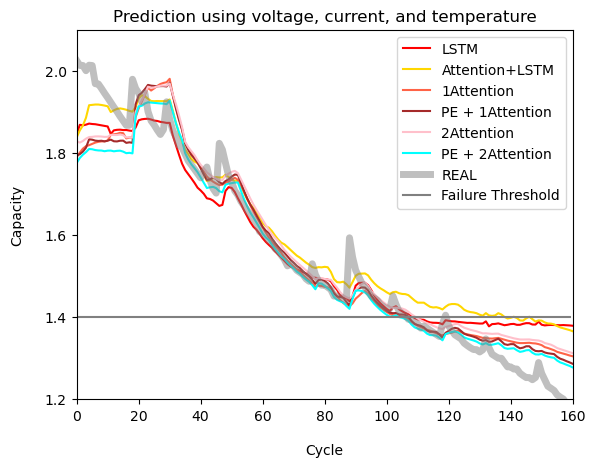

In [3]:
plt.plot(range(len(real.index)), MC_LSTM.iloc[:,0], label="LSTM", color = 'red')
plt.plot(range(len(real.index)), MC_AttentionLSTM.iloc[:,0], label="Attention+LSTM", color = 'gold')
plt.plot(range(len(real.index)), MC_1MAttn.iloc[:,0], label="1Attention", color = 'tomato')
plt.plot(range(len(real.index)), MC_PE_1MAttn.iloc[:,0], label="PE + 1Attention", color = 'brown')
plt.plot(range(len(real.index)), MC_2MAttn.iloc[:,0], label="2Attention", color = 'pink')
plt.plot(range(len(real.index)), MC_PE_2MAttn.iloc[:,0], label="PE + 2Attention", color = 'cyan')

plt.plot(range(len(real.index)), real["capacity"], label="REAL", color="gray", linewidth=5, alpha=0.5)
plt.plot(range(160), [1.4 for i in range(160)], label='Failure Threshold', color='gray')

plt.xlim([0, 160])
plt.ylim([1.2, 2.1])
plt.title("Prediction using voltage, current, and temperature")
plt.xlabel(xlabel='Cycle', labelpad=15)
plt.ylabel(ylabel='Capacity', labelpad=15)
plt.legend()
plt.show()

### RMSE / MAPE / 사용 파라미터 수 비교

In [4]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
def smape(A, F):
    return 100/len(A) * np.sum(2 * np.abs(F - A) / (np.abs(A) + np.abs(F)))

compare_view = pd.DataFrame(columns=['Name','RMSE', 'MAPE(%)', 'SMAPE(%)','파라미터 수'])

all_models_predicts = [MC_LSTM, MC_AttentionLSTM, MC_1MAttn, MC_PE_1MAttn, MC_2MAttn, MC_PE_2MAttn]
model_names = ['LSTM(논문)', 'Attention+LSTM(논문)', '1*Multi_Head_Attn', 'PE_1*Multi_Head_Attn', '2*Multi_Head_Attn', 'PE_2*Multi_Head_Attn(제안)']
model_params = [7471, 11197, 3757, 3757, 5167, 5167]

for name, params, model in zip(model_names, model_params,all_models_predicts): 
    RMSE = np.round(mean_squared_error(real.values.reshape(-1), model.values.reshape(-1)) ** 0.5, 5)
    MAPE = np.round(mean_absolute_percentage_error(real.values.reshape(-1), model.values.reshape(-1)) * 100, 3)
    SMAPE = np.round(smape(real.values.reshape(-1), model.values.reshape(-1)), 3)
    
    row = pd.DataFrame([[name, RMSE, MAPE, SMAPE, params]], columns=['Name','RMSE', 'MAPE(%)', 'SMAPE(%)', '파라미터 수'])

    compare_view = pd.concat([compare_view, row], axis=0)


In [5]:
# EoL(cycle) 예측

EoL_diff_list = []

real_EoL_cycle = 0
for cap in real.values.reshape(-1):
    real_EoL_cycle += 1
    if cap <= 1.4:
        break
print("real" , real_EoL_cycle)

for model in all_models_predicts:
    EoL_cycle = 0
    for cap in model.values.reshape(-1):
        EoL_cycle += 1

        if cap <= 1.4:
            break
    print(EoL_cycle)
    EoL_diff_list.append(EoL_cycle - real_EoL_cycle)

EoL_diff_Series = pd.Series(EoL_diff_list,name="EoL Cycle from baseline(real = 108)", dtype=int)
EoL_diff_Series

real 108
110
140
107
109
111
106


0     2
1    32
2    -1
3     1
4     3
5    -2
Name: EoL Cycle from baseline(real = 108), dtype: int64

In [6]:
compare_view['EoL Cycle diff(real = 108)'] = EoL_diff_list
compare_view.set_index("Name")

,RMSE,MAPE(%),SMAPE(%),파라미터 수,EoL Cycle diff(real = 108)
Name,,,,,
LSTM(논문),0.08270,4.024,3.898,7471,2
Attention+LSTM(논문),0.08323,4.683,4.519,11197,32
1*Multi_Head_Attn,0.07156,3.253,3.225,3757,-1
PE_1*Multi_Head_Attn,0.06801,3.064,3.049,3757,1
2*Multi_Head_Attn,0.07121,3.595,3.543,5167,3
PE_2*Multi_Head_Attn(제안),0.06853,2.831,2.844,5167,-2
